<a href="https://colab.research.google.com/github/KamonohashiPerry/kaggle/blob/master/DSB2019_BS_26_(lgb_auc%2Bxgb)_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
https://www.kaggle.com/steubk/dsb2019-bs-26-lgb-auc-xgb

In [1]:
from google.colab import files
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename =  "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

In [0]:
!pip install kaggle

In [2]:
!kaggle competitions list

ref                                            deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started   Knowledge       2344           False  
titanic                                        2030-01-01 00:00:00  Getting Started   Knowledge      15812            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started   Knowledge       5018            True  
connectx                                       2030-01-01 00:00:00  Getting Started   Knowledge        378           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research          Knowledge         63           False  
competitive-data-science-predict-future-sales  2020-12-31 23:59:00  Playground            Kudos       5604            True  


In [3]:
!kaggle competitions download -c data-science-bowl-2019

  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 44.7MB/s]
  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 30.0MB/s]
 97% 384M/397M [00:02<00:00, 114MB/s]
100% 397M/397M [00:02<00:00, 140MB/s]
  0% 0.00/399k [00:00<?, ?B/s]
100% 399k/399k [00:00<00:00, 124MB/s]
 96% 39.0M/40.8M [00:00<00:00, 76.8MB/s]
100% 40.8M/40.8M [00:00<00:00, 136MB/s] 


In [0]:
# !pip install bayesian-optimization

In [0]:
import numpy as np
import pandas as pd

from random import seed
from random import randint
# seed random number generator
seed(44)

from tqdm import tqdm
import pickle
from numba import jit 
from scipy import stats
import json
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import roc_auc_score

from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# garbage collection
import gc
import os
import psutil

import warnings
warnings.filterwarnings("ignore")

def rmse(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

def eval_qwk_lgb_regr(y_pred, accuracy_groups):
  """
  Fast kappa eval function for lgb.
  """
  # 辞書形式で集計してくれる
  dist = Counter(accuracy_groups)
  # それらを比率のデータに変える
  for k in dist:
    dist[k] /= len(accuracy_groups)
  
  acum = 0
  bound = {}

  # 予測した値を累積の割合に応じてパーセンタイルで表現する。
  for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(y_pred, acum*100)

  def classify(x):
    if x <= bound[0]:
      return 0
    elif x <= bound[1]:
      return 1
    elif x <= bound[2]:
      return 2
    else:
      return 3
    
  y_pred = np.array(list(map(classify, y_pred)))

  return y_pred

@jit
# quadratic weighted kappa
def qwk3(a1, a2, max_rat=3):
  # 条件式がTrueではない時に、例外を投げてくれる関数
  # 同じでない場合に、AssertionErrorが発生する
  assert(len(a1) == len(a2))
  a1 = np.asarray(a1, dtype=int)
  a2 = np.asarray(a2, dtype=int)

  hist1 = np.zeros((max_rat + 1, ))
  hist2 = np.zeros((max_rat + 1, ))

  o = 0
  for k in range(a1.shape[0]):
    i, j = a1[k], a2[k]
    hist1[i] += 1
    hist2[j] += 1
    o += (i - j) * (i - j)

  e = 0

  for i in range(max_rat + 1):
    for j in range(max_rat + 1):
      e += hist1[i] * hist2[j] * (i - j)*(i - j)

  e = e / a1.shape[0]

  return 1 - o / e

# 予測値をグループに変換
def round_prediction(x, a, b, c):
  x = np.where(x < a, 0, x)
  x = np.where((a < x) & (x <= a + b), 1, x)
  x = np.where((a + b < x) & (x <= a + b + c), 2, x)
  x = np.where((a + b + c < x), 3, x)
  return x

In [5]:
ls

adc.json      sample_submission.csv  test.csv.zip   train_labels.csv.zip
sample_data/  specs.csv              train.csv.zip


In [0]:
def dataframe_from64_to32_converter(dataframe):
  import numpy as np
  for column in dataframe.columns:
    if dataframe[column].dtype == 'float64':
      dataframe[column] = dataframe[column].astype(np.float32)
    if dataframe[column].dtype == 'int64':
      dataframe[column] = dataframe[column].astype(np.int32)
  return dataframe

In [0]:
def read_data():
  print('Reading train.csv file....')
  train = pd.read_csv('/content/train.csv.zip')
  train = dataframe_from64_to32_converter(train)
  print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

  print('Reading test.csv file....')
  test = pd.read_csv('/content/test.csv.zip')
  test = dataframe_from64_to32_converter(test)
  print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

  print('Reading train_labels.csv file....')

  train_labels = pd.read_csv('/content/train_labels.csv.zip')
  print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

  print('Reading specs.csv file....')
  specs = pd.read_csv('/content/specs.csv')
  print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

  print('Reading sample_submission.csv file....')

  sample_submission = pd.read_csv('/content/sample_submission.csv')
  print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
  return train, test, train_labels, specs, sample_submission


In [0]:
def encode_title(train, test, train_labels):
  print("Start encoding data")

  # encode title
  train['title_event_code'] = sorted(list(map(lambda x, y :str(x) + '_' + str(y), train['title'], train['event_code'])))
  test['title_event_code'] = sorted(list(map(lambda x, y :str(x) + '_' + str(y), test['title'], test['event_code'])))
  all_title_event_code = sorted(list(set(train['title_event_code'].unique()).union(test['title_event_code'].unique())))

  # world
  train['type_world'] = sorted(list(map(lambda x, y : str(x) + '_' + str(y), train['type'], train['world'])))
  test['type_world'] = sorted(list(map(lambda x, y : str(x) + '_' + str(y), test['type'], test['world'])))
  all_type_world = sorted(list(set(train['type_world'].unique()).union(test['type_world'].unique())))

  # make a list with all the unique 'titles' from the train and test set
  list_of_user_activities = sorted(list(set(train['title'].unique()).union(set(test['title'].unique()))))

  # make a list with all the unique 'event_code' from the train and test set
  list_of_event_code = sorted(list(set(train['event_code'].unique()).union(set(test['event_code'].unique()))))
  list_of_event_id = sorted(list(set(train['event_id'].unique()).union(set(test['event_id'].unique()))))

  # make a list with all the unique worlds from the train and test set
  list_of_worlds = sorted(list(set(train['world'].unique()).union(set(test['world'].unique()))))

  # create a dictionary numerating the titles
  activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
  activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))

  activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
  assess_titles = sorted(list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).\
                              union(set(test[test['type'] == 'Assessment']['title'].value_counts().index))))
  
  # replace the text titles with the number titles from the dict
  train['title'] = train['title'].map(activities_map)
  test['title']  = test['title'].map(activities_map)
  train['world'] = train['world'].map(activities_world)
  test['world'] = test['world'].map(activities_world)
  train_labels['title'] = train_labels['title'].map(activities_map)
  win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))

  # then, it set one element, the 'Bird Measurer(Assessment)' as 4110, 10 more than the rest
  win_code[activities_map['Bird Measurer (Assessment)']] = 4110

  # convert text into datetime
  train['timestamp'] = pd.to_datetime(train['timestamp'])
  test['timestamp'] = pd.to_datetime(test['timestamp'])

  event_data = {}
  event_data['train_labels'] = train_labels
  event_data['win_code'] = win_code
  event_data['list_of_user_activities'] = list_of_user_activities
  event_data['list_of_event_code'] = list_of_event_code
  event_data["activities_labels"] = activities_labels
  event_data["assess_titles"] = assess_titles
  event_data["list_of_event_id"] = list_of_event_id
  event_data["all_title_event_code"] = all_title_event_code
  event_data["activities_map"] = activities_map
  event_data["all_type_world"] = all_type_world

  return train, test, event_data

In [0]:
def get_all_features(feature_dict, ac_data):
  if len(ac_data['durations']) > 0:
    feature_dict['installation_duration_mean'] = np.mean(ac_data['durations'])
    feature_dict['installation_duration_sum'] = np.sum(ac_data['durations'])

  else:
    feature_dict['installation_duration_mean'] = 0
    feature_dict['installation_duration_sum'] = 0

  return feature_dict

In [0]:
# ここに入力される時点でユーザー単位（installation_idごと）のデータになっている。
# game_sessionごとに集計
# Activity→何をどれだけ体験したのかを集計
# Game→ミスなども集計、jsonファイルを解析してステージやレベルやプレイ時間なども集計、正答したかどうかも集計。
# 最後の正答や、最後から2番目の正答なども集計、何のゲームをしたかも集計。
# Assessment→
# test_setはどんなものを想定しているか？

def get_data(user_sample, event_data, test_set):
    '''
    The user_sample is a DataFrame from train or test where the only one
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_assesment = {}

    last_activity = 0

    user_activities_count = {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}

    assess_4020_acc_dict = {'Cauldron Filler (Assessment)_4020_accuracy': 0,
                            'Mushroom Sorter (Assessment)_4020_accuracy': 0,
                            'Bird Measurer (Assessment)_4020_accuracy': 0,
                            'Chest Sorter (Assessment)_4020_accuracy': 0}

    game_time_dict = {'Clip_gametime': 0, 'Game_gametime': 0,
                      'Activity_gametime': 0, 'Assessment_gametime': 0}

    last_session_time_sec = 0
    accuracy_groups = {0: 0, 1: 0, 2: 0, 3: 0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0

    # Newly added features
    accumulated_game_miss = 0
    Cauldron_Filler_4025 = 0
    mean_game_round = 0
    mean_game_duration = 0
    mean_game_level = 0
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    chest_assessment_uncorrect_sum = 0

    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    durations_game = []
    durations_activity = []
    last_accuracy_title = {'acc_' + title: -1 for title in event_data["assess_titles"]}
    last_game_time_title = {'lgt_' + title: 0 for title in event_data["assess_titles"]}
    ac_game_time_title = {'agt_' + title: 0 for title in event_data["assess_titles"]}
    ac_true_attempts_title = {'ata_' + title: 0 for title in event_data["assess_titles"]}
    ac_false_attempts_title = {'afa_' + title: 0 for title in event_data["assess_titles"]}
    event_code_count: dict[str, int] = {ev: 0 for ev in event_data["list_of_event_code"]}
    event_code_proc_count = {str(ev) + "_proc" : 0. for ev in event_data["list_of_event_code"]}
    event_id_count: dict[str, int] = {eve: 0 for eve in event_data["list_of_event_id"]}
    title_count: dict[str, int] = {eve: 0 for eve in event_data["activities_labels"].values()}
    title_event_code_count: dict[str, int] = {t_eve: 0 for t_eve in event_data["all_title_event_code"]}
    type_world_count: dict[str, int] = {w_eve: 0 for w_eve in event_data["all_type_world"]}
    session_count = 0
    
    Activity_game_durations = [] 

    last_Game_Features = {}
    last_game_session_correct_true = np.nan
    last_game_session_correct_false = np.nan

    last_2_game_session_correct_true = np.nan
    last_2_game_session_correct_false = np.nan

    acc_game_session_correct_true = 0
    acc_game_session_correct_false = 0

    last_Assessment_Features = {}

    
    last_Activity_Features = {}
    
    session_type_story = []
    
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = event_data["activities_labels"][session_title]
        game_session = session['game_session'].iloc[0]
        
        session_world = session['world'].iloc[0]
        
        timestamp = session['timestamp'].iloc[0]
        
        if session_type == "Activity":
            # game_sessionごとにイベントカウントを足し合わせていく。
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1]) / 2.0
            # 期間の差分を計算
            durations_activity.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)
            
            last_Activity_Features = {
                "last_activity_event_count":session["event_count"].values[-1],
                "last_activity_event_count_nunique" : session["event_count"].nunique(),
                "last_activity_timestamp": timestamp,
                "last_activity_world": session_world, 
                "last_activity_session_title": session_title
            }
            
        if session_type == "Game":
            # game_sessionごとにイベントカウントを足し合わせていく。
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1]) / 2.0

            # game_sessionでevent_codeが特定のものに絞る。
            game_s = session[session.event_code == 2030]
            # ミスのカウントをする
            misses_cnt = cnt_miss(game_s)
            # 累積のミスをカウントする
            accumulated_game_miss += misses_cnt

            # jsonのパース
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                # ゲームのラウンドの回数の平均
                mean_game_round = (mean_game_round + game_round) / 2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                # ゲームの期間の平均
                mean_game_duration = (mean_game_duration + game_duration) / 2.0
            except:
                pass

            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                # ゲームレベルの平均
                mean_game_level = (mean_game_level + game_level) / 2.0
            except:
                pass

            
            # gameで正解したかどうかのデータ
            game_session_correct = session [ session["event_data"].map(lambda x: '"correct"' in x ) ]["event_data"].map(lambda x: json.loads(x)["correct"])
            last_2_game_session_correct_true = last_game_session_correct_true # 初期値はnp.nan
            last_2_game_session_correct_false = last_game_session_correct_false # 初期値はnp.nan
            
            # gameで正解した回数を集計
            last_game_session_correct_true = game_session_correct.sum()
            # ゲームの回数から正解を差っ引いたものでミスの回数を集計
            last_game_session_correct_false = game_session_correct.shape[0] - last_game_session_correct_true

            # 累積の正解の回数
            acc_game_session_correct_true += last_game_session_correct_true
            # 累積の失敗の回数
            acc_game_session_correct_false += last_game_session_correct_false
        
            # ゲームの期間
            durations_game.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)
            
            last_Game_Features = {
                "last_game_event_count":session["event_count"].values[-1],
                "last_game_event_count_nunique" : session["event_count"].nunique(),
                "last_game_timestamp": timestamp,
                "last_game_world": session_world,
                "last_game_session_title": session_title
            }

            
        # for each assessment, and only this kind of session, the features below are processed
        # and a register are generated
        # アセスメントかつ、テストセットの場合あるいはgame_sessionの数が2以上の場合に処理する。
        if (session_type == 'Assessment') & (test_set or len(session) > 1):
            
            # search for event_code 4100, that represents the assessments trial
            # アセスメントを示すイベントコードのものを絞り込む。
            all_attempts = session.query(f'event_code == {event_data["win_code"][session_title]}')
            
            # then, check the numbers of wins and the number of losses
            # アセスメントの成功した数の集計
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            # アセスメントの失敗した数の集計
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            # copy a dict to use as feature template, it's initialized with some items:
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            # 初期化
            features = user_activities_count.copy()
            # これ以降のupdateでどのような処理が起きるのか？
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(game_time_dict.copy())
            features.update(event_id_count.copy())
            features.update(title_event_code_count.copy())
            features.update(assess_4020_acc_dict.copy())
            features.update(type_world_count.copy())
            features.update(last_game_time_title.copy())
            features.update(ac_game_time_title.copy())
            features.update(ac_true_attempts_title.copy())
            features.update(ac_false_attempts_title.copy())

            features.update(event_code_proc_count.copy())
            features['installation_session_count'] = session_count
            features['game_session'] =  game_session
            features['timestamp'] =  timestamp
            features['accumulated_game_miss'] = accumulated_game_miss
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['chest_assessment_uncorrect_sum'] = chest_assessment_uncorrect_sum

            variety_features = [('var_event_code', event_code_count),
                                ('var_event_id', event_id_count),
                                ('var_title', title_count),
                                ('var_title_event_code', title_event_code_count),
                                ('var_type_world', type_world_count)]

            # featuresに辞書形式のデータのvalueを列として追加していく。
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                # 非ゼロの値の数をカウントする
                features[name] = np.count_nonzero(arr)

            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts
            accumulated_uncorrect_attempts += false_attempts

            # ----------------------------------------------
            # タイトルごとの正答数の集計
            ac_true_attempts_title['ata_' + session_title_text] += true_attempts
            # タイトルごとの誤答数の集計
            ac_false_attempts_title['afa_' + session_title_text] += false_attempts

            # 最後に行ったゲームごとのゲーム時間
            last_game_time_title['lgt_' + session_title_text] = session['game_time'].iloc[-1
            # ゲームごとのゲーム時間の累積                                                                              ]
            ac_game_time_title['agt_' + session_title_text] += session['game_time'].iloc[-1]
            # ----------------------------------------------
            
            # アプリの使用時間
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = np.nan
                features['duration_std'] = np.nan
                features['last_duration'] = np.nan
                features['last-2_duration'] = np.nan
                features['duration_max'] = np.nan
                #features['duration_min'] = np.nan
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                features['last_duration'] = durations[-1]
                if len(durations)>1:
                    features['last-2_duration'] = durations[-2]
                else:
                    features['last-2_duration'] = np.nan
                features['duration_max'] = np.max(durations)
                #features['duration_min'] = np.min(durations)
            
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)

            # ゲームのプレイ時間
            if durations_game == []:
                features['duration_game_mean'] = np.nan
                features['duration_game_std'] = np.nan
                features['game_last_duration'] = np.nan
                features['game_last-2_duration'] = np.nan
                features['game_max_duration'] = np.nan
                #features['game_min_duration'] = np.nan
            else:
                features['duration_game_mean'] = np.mean(durations_game)
                features['duration_game_std'] = np.std(durations_game)
                features['game_last_duration'] = durations_game[-1]
                if len(durations_game)>1:
                    features['game_last-2_duration'] = durations_game[-2]
                else:
                    features['game_last-2_duration'] = np.nan
                features['game_max_duration'] = np.max(durations_game)
                #features['game_min_duration'] = np.min(durations_game)

            # 最後にプレイしたゲームの情報
            if last_Game_Features  == {}:
                features["last_game_event_count"] = np.nan
                features["last_game_event_count_nunique"] = np.nan
                features["last_game_timestamp"] = np.nan
                features["last_game_world_is_the_same"] = np.nan
                features["last_game_session_title"] = np.nan
            else:
                features["last_game_event_count"] =  last_Game_Features["last_game_event_count"]
                features["last_game_event_count_nunique"] =  last_Game_Features["last_game_event_count_nunique"]
                features["last_game_timestamp"] = last_Game_Features["last_game_timestamp"]
                features["last_game_world_is_the_same"] = int(last_Game_Features["last_game_world"] == session_world)
                features["last_game_session_title"] = last_Game_Features["last_game_session_title"]

            # 最後のアセスメントの情報
            if last_Assessment_Features  == {}:
                features["last_assessment_event_count"] = np.nan
                features["last_assessment_event_count_nunique"] = np.nan
                features["last_assessment_timestamp"] = np.nan
                features["last_assessment_world_is_the_same"] = np.nan
                features["last_assessment_title_is_the_same"] = np.nan
                features["last_assessment_accuracy_group"] = np.nan
                features["last_assessment_session_title"] = np.nan
                
            else:
                features["last_assessment_event_count"] =  last_Assessment_Features["last_assessment_event_count"]
                features["last_assessment_event_count_nunique"] =  last_Assessment_Features["last_assessment_event_count_nunique"]
                features["last_assessment_timestamp"] = last_Assessment_Features["last_assessment_timestamp"]
                features["last_assessment_world_is_the_same"] = int(last_Assessment_Features["last_assessment_world"] == session_world)
                features["last_assessment_title_is_the_same"] = int(last_Assessment_Features["last_assessment_title"] == session_title)
                features["last_assessment_accuracy_group"] = last_Assessment_Features["last_assessment_accuracy_group"]
                features["last_assessment_session_title"] = last_Assessment_Features["last_assessment_title"]

            # 最後のアクティビティの情報
            if last_Activity_Features  == {}:
                features["last_activity_event_count"] = np.nan
                features["last_activity_event_count_nunique"] = np.nan
                features["last_activity_timestamp"] = np.nan
                features["last_activity_world_is_the_same"] = np.nan
                features["last_activity_session_title"] = np.nan
            else:
                features["last_activity_event_count"] =  last_Activity_Features["last_activity_event_count"]
                features["last_activity_event_count_nunique"] =  last_Activity_Features["last_activity_event_count_nunique"]
                features["last_activity_timestamp"] = last_Activity_Features["last_activity_timestamp"]
                features["last_activity_world_is_the_same"] = int(last_Activity_Features["last_activity_world"] == session_world)
                features["last_activity_session_title"] = last_Activity_Features["last_activity_session_title"]
                
            # アクティビティの時間
            if durations_activity == []:
                #features['duration_activity_mean'] = np.nan
                #features['duration_activity_std'] = np.nan
                #features['activity_last_duration'] = np.nan
                #features['activity_last-2_duration'] = np.nan
                #features['activity_max_duration'] = np.nan
                features['activity_min_duration'] = np.nan
            else:
                #features['duration_activity_mean'] = np.mean(durations_activity)
                #features['duration_activity_std'] = np.std(durations_activity)
                #features['activity_last_duration'] = durations_activity[-1]
                #if len(durations_activity)>1:
                #    features['activity_last-2_duration'] = durations_activity[-2]
                #else:
                #    features['activity_last-2_duration'] = np.nan
                #features['activity_max_duration'] = np.max(durations_activity)
                features['activity_min_duration'] = np.min(durations_activity)

            # 累積の正答率
            # the accuracy is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy / counter if counter > 0 else 0

            # 特定のアセスメントに関する情報
            # --------------------------
            features['Cauldron_Filler_4025'] = Cauldron_Filler_4025 / counter if counter > 0 else 0

            Assess_4025 = session[(session.event_code == 4025) & (session.title == 'Cauldron Filler (Assessment)')]
            true_attempts_ = Assess_4025['event_data'].str.contains('true').sum()
            false_attempts_ = Assess_4025['event_data'].str.contains('false').sum()

            cau_assess_accuracy_ = true_attempts_ / (true_attempts_ + false_attempts_) if (true_attempts_ + false_attempts_) != 0 else 0
            Cauldron_Filler_4025 += cau_assess_accuracy_

            chest_assessment_uncorrect_sum += len(session[session.event_id == "df4fe8b6"])

            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1]) / 2.0
            # ----------------------------

            # assessmentごとの正答率
            accuracy = true_attempts / (true_attempts + false_attempts) if (true_attempts + false_attempts) != 0 else 0
            # 累積の正答率
            accumulated_accuracy += accuracy
            # 最後のタイトルごとの正答率
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            # グループの付与
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)

            # 該当するグループに対して1を足す。
            accuracy_groups[features['accuracy_group']] += 1

            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group / counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']

            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions # 最初は0

            # タイトルに応じて、現在の評価に関する特徴量を作る。（必要だろうと思ったが作れていなかったもの。）
            features["acc_current_assessment"] = features["acc_"+session_title_text]
            features["lgt_current_assessment"] = features["lgt_"+session_title_text]
            features["agt_current_assessment"] = features["agt_"+session_title_text]
            features["ata_current_assessment"] = features["ata_"+session_title_text]
            features["afa_current_assessment"] = features["afa_"+session_title_text]
            
            features["current_4020_accuracy"] = features.get(session_title_text + "_4020_accuracy",-1)
  
            #for _event in ['2000','2010','2020','2030','3010','3020','3021','3110','3120',
            #              '3121','4020','4030','4035','4040','4070','4080','4090','4100']:
            #    features["current_assessment_" + _event] = features.get(session_title_text + "_" + _event,0)

            # 最後や最後から2番目に行ったゲームの正答など
            features["last_game_session_correct_true"] = last_game_session_correct_true
            features["last_game_session_correct_false"] = last_game_session_correct_false
            features["last_2_game_session_correct_true"] = last_2_game_session_correct_true
            features["last_2_game_session_correct_false"] = last_2_game_session_correct_false
            
            features["acc_game_session_correct_true"] = acc_game_session_correct_true
            features["acc_game_session_correct_false"] = acc_game_session_correct_false
            
            session_type_story_length = len(session_type_story) # 最初は空箱、下のほうでsession_typeをappendしていく。
            features["session_type_story_length"] = session_type_story_length
            features["session_type_story_count_clip"] = session_type_story.count('Clip')
            features["session_type_story_count_game"] = session_type_story.count('Game')
            features["session_type_story_count_activity"] = session_type_story.count('Activity')
            features["session_type_story_count_assessment"] = session_type_story.count('Assessment')
            
            session_type_story = []
            
            last_Assessment_Features = {
                "last_assessment_event_count": session["event_count"].values[-1],
                "last_assessment_event_count_nunique" : session["event_count"].nunique(),
                "last_assessment_timestamp": timestamp,
                "last_assessment_world": session_world,
                "last_assessment_title": session_title,
                "last_assessment_accuracy_group": features['accuracy_group'] 
            }


            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                last_assesment = features.copy()

            if true_attempts + false_attempts > 0:
                all_assessments.append(features)

                
            counter += 1


        session_count += 1

        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(session[col])
            for k in num_of_session_count.keys():
                x = k
                if col == 'title':
                    x = event_data["activities_labels"][k]
                counter[x] += num_of_session_count[k]
            return counter

        def update_proc(count: dict):
            res = {}
            for k, val in count.items():
                res[str(k) + "_proc"] = (float(val) * 100.0) / accumulated_actions
            return res

        event_code_count = update_counters(event_code_count, "event_code")


        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')
        type_world_count = update_counters(type_world_count, 'type_world')

        # アセスメントに関して、特定のイベントの場合における正解、不正解の集計、正解率の算出
        # counter_dictを入力して、counter_dictを返す
        assess_4020_acc_dict = get_4020_acc(session, assess_4020_acc_dict, event_data)
        
        game_time_dict[session_type + '_gametime'] = (game_time_dict[session_type + '_gametime'] + (
                    session['game_time'].iloc[-1] / 1000.0)) / 2.0

        
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        event_code_proc_count = update_proc(event_code_count)

        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
       
  
        session_type_story.append ( session_type )

    # if it't the test_set, only the last assessment must be predicted, the previous goes to the dataset
    if test_set:
        return last_assesment, all_assessments
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [0]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

In [0]:
# アセスメントに関して、特定のイベントの場合における正解、不正解の集計、正解率の算出
# counter_dictを入力して、counter_dictを返す
def get_4020_acc(df, counter_dict, event_data):
  for e in ['Cauldron Filler (Assessment)', 'Bird Measurer (Assessment)',
            'Mushroom Sorter (Assessment)', 'Chest Sorter (Assessment)']:
      Assess_4020 = df[(df.event_code == 4020) & (df.title == event_data["activities_map"][e])]
      true_attempts_ = Assess_4020['event_data'].str.contains('true').sum()
      false_attempts_ = Assess_4020['event_data'].str.contains('false').sum()

      measure_assess_accuracy_ = true_attempts_ / (true_attempts_ + false_attempts_)\
                                       if (true_attempts_ + false_attempts_) != 0 else 0
      counter_dict[e + "_4020_accuracy"] += (counter_dict[e + "_4020_accuracy"] + measure_assess_accuracy_) / 2.0

  return counter_dict

In [0]:
# あれ、使っていない？
def get_users_data(users_list, return_dict,  event_data, test_set):
  if test_set:
      for user in users_list:
          return_dict.append(get_data(user, event_data, test_set))
  else:
      answer = []
      for user in users_list:
          answer += get_data(user, event_data, test_set)
      return_dict += answer

In [0]:
# 
# get_data関数とは？
def get_train_and_test_single_proc(train, test, event_data, load_train = False):

    # すでに処理したものがあればそれを読み込む
    if load_train :
        reduce_train = pd.read_pickle (PROCESSED_TRAIN_PATH)
    # 未処理であればこちらを実行
    else:         
        compiled_train = []
        # installation_idごとにループを回す。
        for ins_id, user_sample in tqdm(train.groupby('installation_id', sort=False), total=17000):
            # ユーザーごとのデータをget_data関数に入力し、色々なデータを特徴量として得る。
            compiled_train += get_data(user_sample, event_data, False)
        reduce_train = pd.DataFrame(compiled_train)
    
    compiled_test = []
    compiled_test_to_train = []
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
        # testデータ用の引数をFalseからTrueに変える。
        test_data = get_data(user_sample, event_data, True)
        compiled_test.append(test_data[0])
        compiled_test_to_train += test_data[1]

    reduce_test = pd.DataFrame(compiled_test)
    reduce_test_to_train = pd.DataFrame(compiled_test_to_train)

    return reduce_train, reduce_test, reduce_test_to_train        

In [0]:
# 相関係数が高いものを除外
def remove_correlated_features(reduce_train,features ):
  counter = 0
  to_remove = []
  for feat_a in features:
      for feat_b in features:
          if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
              c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
              if c > 0.9999:
                  counter += 1
                  to_remove.append(feat_b)
                  print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))
  return to_remove

In [0]:
def post_process (df):
  df["hour"]=df["timestamp"].dt.hour
  df["dayofyear"]=df["timestamp"].dt.dayofyear
  df["dayofweek"]=df["timestamp"].dt.dayofweek
  df['sin_hour'] = np.sin(2*np.pi*df["hour"]/24)
  df['cos_hour'] = np.cos(2*np.pi*df["hour"]/24)
  df = df.drop (["hour"], axis = 1)  
  
  df["timestamp"]=df["timestamp"].astype(int)
  df["last_game_timestamp"]=(df["timestamp"] - df["last_game_timestamp"].astype(int)) // 1e6
  df["last_assessment_timestamp"]=(df["timestamp"] - df["last_assessment_timestamp"].astype(int)) // 1e6
  df["last_activity_timestamp"]=(df["timestamp"] - df["last_activity_timestamp"].astype(int)) // 1e6
  
  df["last_game_session_correct_accuracy"] = df["last_game_session_correct_true"]/(df["last_game_session_correct_true"]+df["last_game_session_correct_false"])
  df["last_2_game_session_correct_accuracy"] = df["last_2_game_session_correct_true"]/(df["last_2_game_session_correct_true"]+df["last_2_game_session_correct_false"])
  df["last_game_session_correct_accuracy*last_2_game_session_correct_accuracy"] = df["last_game_session_correct_accuracy"]*df["last_2_game_session_correct_accuracy"]
  
  df["acc_game_session_correct_accuracy"] = df["acc_game_session_correct_true"]/(df["acc_game_session_correct_true"]+df["acc_game_session_correct_false"])
  
  return df

In [0]:
# ランダムサンプリング(100%)して、グループの重複を除き、最初のものを抽出
def truncate_generator (X, y, groups):
  X = X.copy()
  X["__y__"] = y
  X["__groups__"] = groups
  state = 44
  while True:
      X = X.sample(frac=1.0, random_state=state)
      state +=1
      _X = X.drop_duplicates(["__groups__"], keep="first")
      yield _X.drop(["__y__","__groups__"],axis=1), _X["__y__"].values, _X["__groups__"].values  


In [0]:
# yに対して、予測値を与えて、グループごとにランダムサンプリングをしてそれのRMSEとcohen kappaを計算
def trunc_rmse_qwk_score(y,pred,groups, nsamples=5000):
  rmse_scores = np.zeros ( (nsamples, ))
  oof_cohen_scores = np.zeros ( (nsamples, ))
  
  X=pd.DataFrame()
  X["pred"] = pred
  # ランダムサンプリングしてグループごとにユニークに抽出するもの
  truncate_gen = truncate_generator(X, y, groups)
  for i in range (nsamples):
      # 新しい値を返す
      X, y, groups = truncate_gen.__next__()
      pred = X["pred"]
      # RMSEの計算
      rmse_scores [i]= rmse(y, pred)
      # cohen kappaの計算
      oof_cohen_scores [i]= cohen_kappa_score(y,
                                              eval_qwk_lgb_regr(pred, y),
                                              weights = 'quadratic')    
  
  return rmse_scores, oof_cohen_scores

In [0]:
# 5000回ほどサンプリングしてQWKを計算してくれる関数
# truncate_generatorとは？→ランダムサンプリング(100%)して、グループの重複を除き、最初のものを抽出
# qwk3とは？→quadratic weighting kappaを計算する関数。
def trunc_qwk_score(y,pred,groups, nsamples=5000):
  oof_cohen_scores = np.zeros( (nsamples, ))
  
  X=pd.DataFrame()
  X["pred"] = pred
  # ランダムサンプリング(100%)して、グループの重複を除き、最初のものを抽出
  truncate_gen = truncate_generator (X, y, groups)
  for i in range (nsamples):
      # __next__のイテレーターで新しい値を抽出
      X, y, groups = truncate_gen.__next__()
      pred = X["pred"]
      # quadratic weighting kappaの計算
      oof_cohen_scores [i]= qwk3(pred, y)    
  
  return oof_cohen_scores

In [0]:
def trunc_auc_score(y,pred,groups, nsamples=5000):
    scores = np.zeros ( (nsamples, ))
    
    X=pd.DataFrame()
    X["pred"] = pred
    truncate_gen = truncate_generator (X, y, groups)
    for i in range (nsamples):
        X, y, groups = truncate_gen.__next__()
        pred = X["pred"]
        scores [i]= roc_auc_score(y,pred)    
    
    return scores

## LightGBMの訓練等の設定

In [0]:
# out of foldでのLight GBM
# splitsを外から与えてあげる
# groupを外から与えてあげる
# LightGBMの訓練をして、モデルと予測値を返す
def oof_lgb (X, ids, y, groups, num_boost_round, early_stopping_rounds,
             params, categoricals, splits, verbose_eval):
  # 特徴量の列名
  columns = [c for c in X.columns]
  
  oof = pd.DataFrame({"id":ids})
  y_oof = np.zeros((X.shape[0], ))
  
  models= []
  
  # 特徴量重要度
  feature_importances = pd.DataFrame()
  feature_importances['feature'] = columns 

  # 外から与えたsplitで訓練用とバリデーション用の特徴量、教師データを作成する
  for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    #group_train = groups.iloc [train_index] 
    #train_truncate_gen = truncate_generator ( X_train, y_train, group_train)

    # 外から与えたグループでvalidationのインデックスに該当するものを抽出
    group_valid = groups.iloc [valid_index] 
    
    # ランダムサンプリング(100%)して、グループの重複を除き、最初のものを抽出
    truncate_gen = truncate_generator ( X_valid, y_valid, group_valid) 
    
    # 新しい値を返す
    X_valid_trunc, y_valid_trunc, _ = truncate_gen.__next__()
    
    # LightGBM用のデータ型にする
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid_trunc, label=y_valid_trunc)

    # 訓練の実行（訓練とバリデーションデータを一緒に指定する）
    model = lgb.train(params, dtrain, num_boost_round, 
                      valid_sets = [dtrain, dvalid],
                      categorical_feature = categoricals,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stopping_rounds)
    # バリデーションのデータを使って予測
    y_pred = model.predict(X_valid)

    #if verbose_eval > 0:
    #   rmse_scores, oof_cohen_scores = trunc_rmse_qwk_score (y_valid.values, y_pred, group_valid.values,nsamples=5000)
    #    print (f'fold: {fold_n}, rmse: {np.median(rmse_scores)} std:{rmse_scores.std()} , oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}' )
    
    # モデル自体をappendする
    models.append(model)

    # foldの回数ごとの特徴量重要度を蓄積
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importance()

    y_oof[valid_index] = y_pred

    # データの削除
    del X_train, X_valid, y_train, y_valid
    # garbage collection
    gc.collect()

  # fold全体の平均値を取る
  feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' \
                                          for fold_n in range(len(splits))]].mean(axis=1)
  # 平均値が高い順に並べ替える                                        
  feature_importances = feature_importances.sort_values (by="average", ascending = False)
  # 特徴量重要度を保存する
  feature_importances.to_csv("feature_importance.csv", index=False)
  return models, y_oof

In [0]:
# TrainデータでのLight GBM
# GroupKFoldでのクロスバリデーションとなっている。
# oof_lgbとは？→LightGBMの訓練をして、モデルと予測値を返す
def run_lgb (df_train, num_boost_round, early_stopping_rounds,
             params, model_feats,categorical_features, nfolds, verbose_eval  ):
  if verbose_eval > 0:
    print(f'nfolds:{nfolds}, features:{len(model_feats)}, categorical:{len(categorical_features)}')
    
  X = df_train[model_feats]
  # ここは固定。他の分析で使い回す際は変更が必要
  y = df_train["accuracy_group"]
  ids = df_train["sample"]
  groups = df_train["installation_id"]

  folds = GroupKFold(n_splits=nfolds) 

  splits = []
  # GroupKFold用の記述
  for fold_n, (train_index, valid_index) in enumerate(folds.split(X,groups=groups)):
      splits.append((train_index, valid_index)) 

  # LightGBMの訓練をして、モデルと予測値を返す
  lgb_model, y_oof = oof_lgb (X, ids, y, groups,  num_boost_round,
                              early_stopping_rounds, params,
                              categoricals=categorical_features,
                              splits=splits, verbose_eval = verbose_eval)
  
  return lgb_model, y_oof  #, rmse_scores, oof_cohen_scores


In [0]:
# アンサンブルでのLight GBM
# モデルを用いたyの予測値のモデルごとの平均、RMSE、QWKの3つを返す
# run_lgb()とは
def run_lgb_ensemble (df_train, model_feats, categorical_features, num_boost_round, early_stopping_rounds,  params, nmodel,nfolds, verbose_eval ):
  y_oof = np.zeros ( (df_train.shape[0],) )
  for i in range(nmodels):
      lgb_i_models, y_i_oof = run_lgb(df_train, num_boost_round,
                                      early_stopping_rounds, params,
                                      model_feats, categorical_features,
                                      nfolds, verbose_eval )
      y_oof += y_i_oof 
      for n,model in enumerate(lgb_i_models):
          # モデルの保存
          model.save_model(f'lgb_{i}_model_fold_{n}.txt')
      params['seed'] +=1
      params['feature_fraction_seed'] +=1
      params['bagging_seed'] +=1
      params['drop_seed'] +=1
      params['data_random_seed'] +=1            
  
  y_oof = y_oof / nmodels
  
  # yに対して、予測値を与えて、グループごとにランダムサンプリングをしてそれのRMSEとcohen kappaを計算
  # installation_idをグループとして指定している。
  rmse_scores,  oof_cohen_scores  = trunc_rmse_qwk_score ( df_train["accuracy_group"].values,
                                                          y_oof,
                                                          df_train["installation_id"].values, 
                                                          nsamples=5000)
  print (f'lgb {nmodels} models rmse: {np.median(rmse_scores)} std:{rmse_scores.std()} , oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')
  
  return y_oof, rmse_scores,  oof_cohen_scores


In [0]:
# yを外から与えている。
def run_lgb_auc (df_train, y, num_boost_round, early_stopping_rounds,  params, model_feats,categorical_features, nfolds, verbose_eval  ):
  if verbose_eval > 0:
      print(f'nfolds:{nfolds}, features:{len(model_feats)}, categorical:{len(categorical_features)}')
  
  X = df_train[model_feats]

  ids = df_train["sample"]
  groups = df_train["installation_id"]

  folds = GroupKFold(n_splits=nfolds) 

  splits = []
  for fold_n, (train_index, valid_index) in enumerate(folds.split(X,groups=groups)):
      splits.append((train_index, valid_index)) 

  lgb_model, y_oof = oof_lgb (X, ids, y, groups,  num_boost_round, early_stopping_rounds, params, categoricals=categorical_features, splits=splits, verbose_eval = verbose_eval)
  
  return lgb_model, y_oof  #, rmse_scores, oof_cohen_scores

In [0]:
def run_lgb_auc_ensemble (df_train, y, name,  model_feats, categorical_features, num_boost_round, early_stopping_rounds,  params, nmodel,nfolds, verbose_eval ):
  y_oof = np.zeros ( (df_train.shape[0],) )
  for i in range(nmodels):
      lgb_i_models, y_i_oof  = run_lgb_auc(df_train, y, num_boost_round, early_stopping_rounds, params, model_feats, categorical_features,  nfolds, verbose_eval )
      y_oof += y_i_oof 
      for n,model in enumerate(lgb_i_models):
          # モデルの保存
          model.save_model(f'lgb_{name}_{i}_model_fold_{n}.txt')
      params['seed'] +=1
      params['feature_fraction_seed'] +=1
      params['bagging_seed'] +=1
      params['drop_seed'] +=1
      params['data_random_seed'] +=1            
  
  y_oof = y_oof / nmodels
  
  auc_scores  = trunc_auc_score ( y.values, y_oof, df_train["installation_id"].values, nsamples=5000)
  print (f'lgb {nmodels} models auc: {np.median(auc_scores)} std:{auc_scores.std()}')
  
  return y_oof, auc_scores


## XGBoostの訓練等の設定

In [0]:
def oof_xgb (X, ids, y, groups,num_boost_round, early_stopping_rounds, params, splits, verbose_eval):
  columns = [c for c in X.columns]
  
  oof = pd.DataFrame({"id":ids})
  y_oof = np.zeros((X.shape[0], ))
  
  models= []
  score = 0
  for fold_n, (train_index, valid_index) in enumerate(splits):
      X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
      y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

      group_valid = groups.iloc [valid_index] 
      
      truncate_gen = truncate_generator ( X_valid, y_valid, group_valid) 
      
      X_valid_trunc, y_valid_trunc, _ = truncate_gen.__next__()
    
  
      dtrain = xgb.DMatrix(X_train,label=y_train)
      dvalid = xgb.DMatrix(X_valid_trunc,label=y_valid_trunc)
      
      model = xgb.train(params, dtrain=dtrain, num_boost_round=num_boost_round, evals =  [(dtrain, 'train'),(dvalid, 'valid')],
                        early_stopping_rounds=early_stopping_rounds, maximize=False, verbose_eval=verbose_eval)


      dvalid = xgb.DMatrix(X_valid,label=y_valid)
      y_pred = model.predict(dvalid)
      
          
          
      models.append(model)

      y_oof[valid_index] = y_pred

      del X_train, X_valid, y_train, y_valid
      gc.collect()

  #rmse_scores, oof_cohen_scores = trunc_rmse_qwk_score (y, y_oof, groups)
  #avg_score = score/len(splits)    
  #if verbose_eval > 0:
  #    print (f'oof rmse: {rmse_scores.median()}, mean rmse: {avg_score}, cohen kappa score : {oof_cohen_scores.median()}')
  
  return models, y_oof

In [0]:
def run_xgb (df_train, num_boost_round, early_stopping_rounds,  params, model_feats,categorical_features, nfolds  , verbose_eval   ):
  if verbose_eval > 0:
      print(f'nfolds:{nfolds}, features:{len(model_feats)}, categorical:{len(categorical_features)}')
  
  X = df_train[model_feats].copy()
  
  X = pd.get_dummies(X, dummy_na=True, columns=categorical_features)
  
  y = df_train["accuracy_group"]
  ids = df_train["sample"]
  groups = df_train["installation_id"]

  folds = GroupKFold(n_splits=nfolds) 

  splits = []
  for fold_n, (train_index, valid_index) in enumerate(folds.split(X,groups=groups)):
      splits.append((train_index, valid_index)) 

  xgb_model, y_oof = oof_xgb (X, ids, y, groups, num_boost_round, early_stopping_rounds, params,  splits=splits, verbose_eval = verbose_eval)
  
  return xgb_model, y_oof

In [0]:
def run_xgb_ensemble (df_train, model_feats, categorical_features, num_boost_round, early_stopping_rounds,  params, nmodel,nfolds, verbose_eval ):
  y_oof = np.zeros ( (df_train.shape[0],) )
  for i in range(nmodels):
      xgb_i_models, y_i_oof  = run_xgb(df_train, num_boost_round, early_stopping_rounds, params, model_feats, categorical_features,  nfolds, verbose_eval )
      y_oof += y_i_oof 
      for n,model in enumerate(xgb_i_models):
          # モデルの保存
          model.save_model(f'xgb_{i}_model_fold_{n}.txt')
      params['seed'] +=1       
  
  y_oof = y_oof / nmodels
  
  # yに対して、予測値を与えて、グループごとにランダムサンプリングをしてそれのRMSEとcohen kappaを計算
  rmse_scores,  oof_cohen_scores  = trunc_rmse_qwk_score ( df_train["accuracy_group"].values,
                                                                y_oof,
                                                                df_train["installation_id"].values,
                                                                nsamples=5000)
  print (f'xgb {nmodels} models rmse: {np.median(rmse_scores)} std:{rmse_scores.std()} , oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')
  
  return y_oof, rmse_scores,  oof_cohen_scores

## LightGBMの予測等の設定

In [0]:
# モデルの数、foldの数だけモデルがあり、それらのモデルを用いた予測のブレンドした値を返す。LightGBM版。
def predict_lgb (nmodel, nfolds):
  y_blend = np.zeros((test.shape[0], ))     
  
  for i in range(nmodels):
      y_test = np.zeros((test.shape[0], ))     

      for n in range(nfolds):
          # 保存してあるモデルの読み込み
          model_file = f'./lgb_{i}_model_fold_{n}.txt'
          model = lgb.Booster(model_file=model_file)
          # モデルを使って予測
          pred = model.predict( test[model_feats], num_iteration=model.best_iteration )
          y_test += pred
      
      y_blend += y_test / nfolds
  
  y_blend = y_blend / nmodels
  
  return y_blend

In [0]:
# モデルの数、foldの数だけモデルがあり、それらのモデルを用いた予測のブレンドした値を返す。
def predict_auc_lgb (name, nmodel, nfolds):
  y_blend = np.zeros((test.shape[0], ))     
  
  for i in range(nmodels):
      y_test = np.zeros((test.shape[0], ))     

      for n in range(nfolds):
          # モデルの格納先(save_model()で保存したもの。run_lgb_auc_ensemble()でnameを指定している。 )
          # foldの数だけモデルがある。
          model_file = f'./lgb_{name}_{i}_model_fold_{n}.txt'
          # モデルの格納先からモデルを読み込む
          model = lgb.Booster(model_file=model_file)
          # 予測
          pred = model.predict( test[model_feats], num_iteration=model.best_iteration )
          y_test += pred
      
      # fold数で割って足していく
      y_blend += y_test / nfolds
  
  # ブレンドしたものをモデルの数で割る
  y_blend = y_blend / nmodels
  
  return y_blend

In [0]:
# モデルの数、foldの数だけモデルがあり、それらのモデルを用いた予測のブレンドした値を返す。（XGBoost版）
def predict_xgb (nmodel, nfolds):
  y_blend = np.zeros((test.shape[0], ))     

  test_xgb = test[model_feats].copy()
  # カテゴリデータのダミー変数を追加している。
  test_xgb = pd.get_dummies(test_xgb,  dummy_na=True, columns=categorical_features)
  
  for i in range(nmodels):
      y_test = np.zeros((test.shape[0], ))     

      for n in range(nfolds):
          # モデルの読み込み
          model_file = f'./xgb_{i}_model_fold_{n}.txt'
          # モデルの初期化
          model = xgb.Booster() #init model
          model.load_model(model_file) # load data

          # XGBoost用のデータの型に変換
          dtest =  xgb.DMatrix (test_xgb)
          pred = model.predict(dtest)           
          y_test += pred
      
      y_blend += y_test / nfolds
  
  y_blend = y_blend / nmodels
  
  return y_blend

In [0]:
def predict(sample_submission, y_pred):
  sample_submission['accuracy_group'] = y_pred
  sample_submission['accuracy_group'] = sample_submission['accuracy_group'].astype(int)
  sample_submission.to_csv('submission.csv', index = False)
  print(sample_submission['accuracy_group'].value_counts(normalize = True))

In [0]:
# out of foldのyのパーセンタイルごとの値を出力する関数
def calc_bound ( y_oof, groups ):
  dist = Counter(groups)
  for k in dist:
      dist[k] /= len(y_oof)

  acum = 0
  bound = {}
  for i in range(3):
      acum += dist[i]
      bound[i] = np.percentile(y_oof, acum * 100)

  return bound[0], bound[1] - bound[0],  bound[2] - bound[1]  

## QWKの閾値の最適化の設定

In [0]:
# QWKを計算する上での最適な階級値を求めるためにベイズ最適化を用いている
# yとy_oofの違い→yは実績、y_oofは予測値
def qwk3_optimizer ( y, y_oof, init_points = 20, n_iter = 50  ):
  # boundの指定。予測値をグループに変換する際のしきい値がa,b,c
  pbounds = {'a': (0.0, 1.5), 'b': (0.0, 1.5), 'c': (0.0, 1.5)}

  # QWKの計算
  # 与えたxをQWKの計算ができるように変換
  def qwk3_opt ( x, y, a,b,c ):
      # 予測値をグループに変換
      x = round_prediction ( x, a,b,c )

      # QWKを計算
      return qwk3 ( x, y, max_rat=3 )


  # 実績値と予測値とのQWKの計算
  def q (a,b,c):
      return qwk3_opt  ( y_oof, y, a,b,c )

  # ベイズ最適化の設定
  optimizer = BayesianOptimization(
      f=q, # functionがQWK
      pbounds=pbounds, 
      random_state=44,
  )

  # 最適化の引数
  optimizer.maximize(
      # How many steps of random exploration you want to perform.
      # Random exploration can help by diversifying the exploration space.
      init_points=init_points,
      # How many steps of bayesian optimization you want to perform. 
      # The more steps the more likely to find a good maximum you are.
      n_iter=n_iter,
  )

  # 最適化した際の値の格納
  a = optimizer.max["params"]["a"]
  b = optimizer.max["params"]["b"]
  c = optimizer.max["params"]["c"]
  t = optimizer.max["target"]
  print ( f'qwk3:{t}, a:{a}, b:{b}, c:{c}' )
  
  return a,b,c 

In [38]:
# foldの数
NFOLDS = 5

# モデルの数
NMODELS = 5 

event_data = {}

# read data
train, test, train_labels, specs, sample_submission = read_data()

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [39]:
# get usefull dict with maping encode
train, test, event_data_update = encode_title(train, test, train_labels)
event_data.update(event_data_update)

Start encoding data


In [45]:
reduce_train, reduce_test, reduce_train_from_test = get_train_and_test_single_proc(train, test, event_data, load_train=False)

reduce_train = post_process(reduce_train)
reduce_test = post_process(reduce_test)
reduce_train_from_test = post_process(reduce_train_from_test)
reduce_train.shape,reduce_test.shape,reduce_train_from_test.shape

100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]


((17690, 1047), (1000, 1047), (2018, 1047))

In [46]:
# delete train and test to release memory
del train, test

# garbage collection
import gc
gc.collect()

2437

In [0]:
reduce_train = reduce_train.append (reduce_train_from_test, sort = False)

In [0]:
test = reduce_test
df_train = reduce_train

df_train["sample"] = df_train["installation_id"] + "_" + df_train["game_session"]
test["sample"]=test["installation_id"]


model_feats = [
'last_game_session_title', 'session_title', '4070_proc', 'acc_game_session_correct_accuracy', 'last_game_session_correct_accuracy',
'4020_proc', 'activity_min_duration', '2030_proc', 'last_game_timestamp', 'acc_current_assessment', '3021_proc', 'ata_current_assessment',
'2000_proc', 'last_2_game_session_correct_accuracy', '2010_proc', 'last_assessment_timestamp', 'last_game_event_count', 'Activity_gametime',
'4025_proc', 'last_activity_event_count', 'accumulated_accuracy', 'duration_mean', 'last_duration', '4090_proc', 'Clip', 'last_assessment_event_count',
'game_last_duration', 'game_last-2_duration', 'accumulated_accuracy_group', '3020_proc', '4040_proc', '4035_proc', 'afa_current_assessment',
'mean_game_duration', 'Activity_mean_event_count', '4030_proc', '4010_proc', '4100_proc', 'duration_std', 'duration_game_mean',
'last_assessment_session_title', '2035_proc', 'sin_hour', '3120_proc', '3110_proc', 'lgt_Cauldron Filler (Assessment)', '2025_proc',
'2080_proc', '3010_proc', '4021_proc', 'session_type_story_count_clip', 'agt_Cart Balancer (Assessment)', '4095_proc', 'Game_mean_event_count',
'2075_proc', 'game_max_duration', '2060_proc', '7372e1a5', 'duration_game_std', '56817e2b', 2000, 'Assessment_gametime', 'mean_game_round',
'15a43e5b', '2083_proc', 'var_title', '3ee399c3', 'cos_hour', 'last_2_game_session_correct_true', 'duration_max', 4035, '4031_proc', '5000_proc',
'4045_proc', 'agt_Cauldron Filler (Assessment)', 'dayofweek', 'bbfe0445', '4220_proc', 'b120f2ac', 'e694a35b', 'lgt_Chest Sorter (Assessment)',
'587b5989', '84538528', 'last_game_session_correct_true', 'current_4020_accuracy', '6bf9e3e1', 'Sandcastle Builder (Activity)', '3afde5dd',
'last_assessment_event_count_nunique', 'last_activity_event_count_nunique', '2081_proc', 3010, 3021, 3020, 'Mushroom Sorter (Assessment)_4020_accuracy',
'51102b85', '1bb5fbdb', '4110_proc', 'accumulated_uncorrect_attempts', 'Bird Measurer (Assessment)_4020_accuracy', '3bf1cf26', 'session_type_story_count_game',
'agt_Chest Sorter (Assessment)', 'agt_current_assessment', '562cec5f', '499edb7c', 'last_assessment_accuracy_group', 'ca11f653', '2040_proc', 4100, 4020,
'0db6d71d', '37ee8496', 'acc_Bird Measurer (Assessment)', 'Game_CRYSTALCAVES', 'acc_game_session_correct_true', 'lgt_Bird Measurer (Assessment)',
'ata_Chest Sorter (Assessment)', '907a054b', '3babcb9b', 'acc_Mushroom Sorter (Assessment)', 'acc_Chest Sorter (Assessment)', 'Bottle Filler (Activity)_4020',
'Game_TREETOPCITY', 'session_type_story_count_activity', 'last_activity_world_is_the_same', 'last_assessment_world_is_the_same', 'last_assessment_title_is_the_same',
]

categorical_features =  [f for f in model_feats if f in ['session_title',
                                                         'last_game_session_title',
                                                         'last_assessment_session_title',
                                                         'last_activity_session_title',                                                         
                                                         'last_assessment_accuracy_group']]

## LightGBMの実行

nfolds:5, features:128, categorical:4
nfolds:5, features:128, categorical:4
nfolds:5, features:128, categorical:4
nfolds:5, features:128, categorical:4
nfolds:5, features:128, categorical:4
lgb 5 models rmse: 1.0279043099955714 std:0.00723593347157421 , oof_cohen: 0.5565094751699389 std:0.008654065293578194


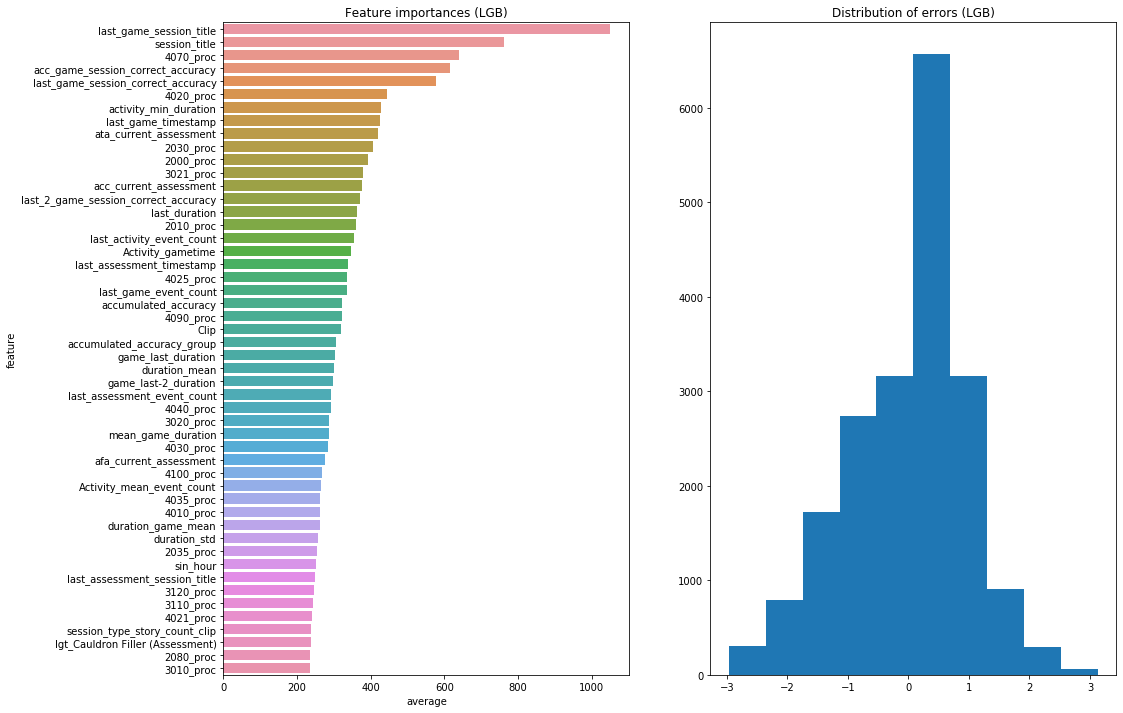

CPU times: user 17min 30s, sys: 6.76 s, total: 17min 37s
Wall time: 9min 38s


In [49]:
%%time
nmodels = NMODELS
nfolds = NFOLDS
num_boost_round = 1600 
early_stopping_rounds = None 
verbose_eval = 2000
lgb_params = {
          'num_leaves': 19, 
          'min_data_in_leaf': 160,
          'min_child_weight': 0.03,
          'bagging_fraction' : 0.7,
          'feature_fraction' : 0.8,
          'learning_rate' : 0.01,
          'max_depth': -1,
          'reg_alpha': 0.02,
          'reg_lambda': 0.12,
          'objective': 'regression',
          'seed': 1337,
          'feature_fraction_seed': 1337,
          'bagging_seed': 1337,
          'drop_seed': 1337,
          'data_random_seed': 1337,
          'boosting_type': 'gbdt',
          'verbose': 100,
          'boost_from_average': False,
          'metric':'rmse'
}        

# アンサンブルでのLightGBM
# モデルを用いたyの予測値のモデルごとの平均、RMSE、QWKの3つを返す
y_oof_lgb, rmse_scores, oof_cohen_scores = run_lgb_ensemble (df_train,
                                                             model_feats,
                                                             categorical_features,
                                                             num_boost_round,
                                                             early_stopping_rounds,
                                                             lgb_params, 
                                                             nmodels, 
                                                             nfolds, verbose_eval )

feature_importances = pd.read_csv("./feature_importance.csv")

fig, ax = plt.subplots(figsize=(16, 12))
plt.subplot(1, 2, 1)
sns.barplot(data=feature_importances[:50], x='average', y='feature', orient='h')
plt.title('Feature importances (LGB)')

plt.subplot(1, 2, 2)
plt.hist(df_train["accuracy_group"].values.reshape(-1, 1) - y_oof_lgb.reshape(-1, 1))
plt.title('Distribution of errors (LGB)')
plt.show()    

In [0]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('RMSE LGB')
plt.hist(rmse_scores, bins=100)

plt.subplot(1, 2, 2)
plt.title('QWK LGB')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'LGB {nmodels} rmse: {np.median(rmse_scores)} std:{rmse_scores.std()} , oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')

In [0]:
# out of boundのyのパーセンタイルを返す、QWKの計算のために必要
# y_oof_lgbはアンサンブルでのLightGBMの予測値
a,b,c = calc_bound (y_oof_lgb, df_train["accuracy_group"])

# trunc_qwk_scoreとは、5000回ほどサンプリングしてQWKを計算するもので、スコアが返される
# round_predictionとは、予測値をグループに変換するもの
# y_oof_lgbってどんな変数？ run_lgb_ensemble()を実行して出力される第1の要素
oof_cohen_scores  = trunc_qwk_score( df_train["accuracy_group"].values, # 教師データ
                                         round_prediction (y_oof_lgb,a,b,c), # アンサンブル学習して予測した値と先程求めた閾値
                                         df_train["installation_id"].values, # このグループごとに計算
                                         nsamples=5000)

fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 1, 1)
plt.title('LGB QWK (percentile opt)')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'a:{a} b:{b} c:{c} oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')

### 最適化

In [0]:
# 予測値をグループにする際の閾値の最適化
# y_oof_lgbはモデルを用いたyの予測値のモデルごとの平均
a,b,c = qwk3_optimizer( df_train["accuracy_group"], y_oof_lgb)

# 最適化より得られた閾値をもとにQWKを計算
oof_cohen_scores  = trunc_qwk_score( df_train["accuracy_group"].values,
                                          round_prediction (y_oof_lgb,a,b,c),
                                          df_train["installation_id"].values,
                                          nsamples=5000)

fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 1, 1)
plt.title('LGB QWK (bayesian opt)')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'a:{a} b:{b} c:{c} oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')

In [0]:
%%time

nmodels = NMODELS
nfolds = NFOLDS
num_boost_round = 1600 
early_stopping_rounds = None 
verbose_eval = 2000
lgb_params = {
          'num_leaves': 19, 
          'min_data_in_leaf': 160,
          'min_child_weight': 0.03,
          'bagging_fraction' : 0.7,
          'feature_fraction' : 0.8,
          'learning_rate' : 0.01,
          'max_depth': -1,
          'reg_alpha': 0.02,
          'reg_lambda': 0.12,
          'objective': 'binary',
          'seed': 1337,
          'feature_fraction_seed': 1337,
          'bagging_seed': 1337,
          'drop_seed': 1337,
          'data_random_seed': 1337,
          'boosting_type': 'gbdt',
          'verbose': 100,
          'boost_from_average': False,
          'metric':'auc'
}        

# カテゴリカル変数の指定
categorical_features =  [f for f in model_feats if f in ['session_title',
                                                         'last_game_session_title',
                                                         'last_assessment_session_title',
                                                         'last_activity_session_title',                                                         
                                                         'last_assessment_accuracy_group']]

# 実行するとモデルの保存も行う。
# 教師データを解けたかどうかにしたバージョン
y_lgb_solved_oof, auc_score = run_lgb_auc_ensemble(df_train, df_train["accuracy_group"].map(lambda x: 0 if x ==0 else 1) , 
                                                   "solved",  model_feats, categorical_features,
                                                   num_boost_round, early_stopping_rounds,
                                                   lgb_params, nmodels, nfolds, verbose_eval )
# 教師データを1回目で解けたかどうかにしたバージョン
y_lgb_first_oof, auc_score = run_lgb_auc_ensemble(df_train, df_train["accuracy_group"].map(lambda x: 1 if x ==3 else 0) ,
                                                  "first",  model_feats, categorical_features, 
                                                  num_boost_round, early_stopping_rounds, 
                                                  lgb_params, nmodels, nfolds, verbose_eval )

## XGBoostの実行

In [0]:
nmodels = NMODELS
nfolds = NFOLDS
num_boost_round = 600 
early_stopping_rounds = None 
verbose_eval = 1000

xgb_params = {
            'objective':'reg:squarederror',
            'eval_metric':'rmse',
            'seed': 1337,
            'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 9,
            'subsample': 0.7,
            'min_child_weight':3,
            'gamma':0.25,
            }    

categorical_features =  [f for f in model_feats if f in ['session_title',
                                                         'last_game_session_title',
                                                         'last_assessment_session_title',
                                                         'last_activity_session_title',                                                         
                                                         'last_assessment_accuracy_group']]

# モデルを用いたyの予測値のモデルごとの平均、RMSE、QWKの3つを返す
y_oof_xgb, rmse_scores,  oof_cohen_scores = run_xgb_ensemble (df_train,
                                                              model_feats,
                                                              categorical_features,
                                                              num_boost_round,
                                                              early_stopping_rounds,
                                                              xgb_params, nmodels,
                                                              nfolds, verbose_eval )

plt.subplot(1, 1, 1)
plt.hist(df_train["accuracy_group"].values.reshape(-1, 1) - y_oof_xgb.reshape(-1, 1))
plt.title('Distribution of errors (XGB)')
plt.show()

In [0]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('RMSE XGB')
plt.hist(rmse_scores, bins=100)

plt.subplot(1, 2, 2)
plt.title('QWK XGB')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'XGB {nmodels} rmse: {np.median(rmse_scores)} std:{rmse_scores.std()} , oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')


In [0]:
# out of foldのyのパーセンタイルごとの値を出力する関数
a,b,c = calc_bound (y_oof_xgb, df_train["accuracy_group"])

# trunc_qwk_scoreとは、5000回ほどサンプリングしてQWKを計算するもので、スコアが返される
# round_predictionとは、予測値をグループに変換するもの
# y_oof_xgbってどんな変数？ を実行して出力される第1の要素

oof_cohen_scores  = trunc_qwk_score ( df_train["accuracy_group"].values,
                                     round_prediction (y_oof_xgb,a,b,c),
                                     df_train["installation_id"].values,
                                     nsamples=5000)

fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 1, 1)
plt.title('XGB QWK (percentile opt)')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'a:{a} b:{b} c:{c} oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')


### 最適化

In [0]:
# 予測値をグループにする際の閾値の最適化
# y_oof_xgbはモデルを用いたyの予測値のモデルごとの平均
a,b,c = qwk3_optimizer ( df_train["accuracy_group"], y_oof_xgb)

# 最適化より得られた閾値をもとにQWKを計算
oof_cohen_scores  = trunc_qwk_score ( df_train["accuracy_group"].values,
                                          round_prediction (y_oof_xgb,a,b,c),
                                          df_train["installation_id"].values,
                                          nsamples=5000)

fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 1, 1)
plt.title('XGB QWK (bayesian opt)')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'a:{a} b:{b} c:{c} oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')

In [0]:
df = pd.DataFrame()
df["accuracy_group"] = df_train["accuracy_group"].values
df["sample"] = df_train["sample"].values
df["installation_id"] = df_train["installation_id"].values
df["y"] = y_oof_lgb
df["y_xgb"] = y_oof_xgb
df["solved"] = y_lgb_solved_oof
df["first"] = y_lgb_first_oof

## アンサンブル

In [0]:
# 様々なモデルの結果の重み付けの平均を計算している。
y = (2*0.7*df["y"] + 2*0.3*df["y_xgb"] + 2*3*df["solved"]  + 3*df["first"])/5

# yに対して、予測値を与えて、グループごとにランダムサンプリングをしてそれのRMSEとcohen kappaを計算
rmse_scores, oof_cohen_scores = trunc_rmse_qwk_score( df_train["accuracy_group"].values,
                                                            y,
                                                            df_train["installation_id"].values,
                                                            nsamples=5000)

np.median(rmse_scores),  np.median(oof_cohen_scores)

In [0]:
# out of foldのyのパーセンタイルごとの値を出力する関数
a,b,c = calc_bound (y, df_train["accuracy_group"])

# trunc_qwk_scoreとは、5000回ほどサンプリングしてQWKを計算するもので、スコアが返される
# round_predictionとは、予測値をグループに変換するもの
# yは様々なモデルの予測結果をブレンドした値
oof_cohen_scores  = trunc_qwk_score( df_train["accuracy_group"].values,
                                    round_prediction(y,a,b,c),
                                    df_train["installation_id"].values,
                                    nsamples=5000)

fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 1, 1)
plt.title('QWK (percentile opt)')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'a:{a} b:{b} c:{c} oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')

# ベイズ最適化により予測値のグループ化に関する閾値を計算
a,b,c = qwk3_optimizer ( df_train["accuracy_group"], y)

# 求めた閾値に関してQWKを計算
oof_cohen_scores  = trunc_qwk_score( df_train["accuracy_group"].values,
                                    round_prediction (y,a,b,c),
                                    df_train["installation_id"].values,
                                    nsamples=5000)

fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 1, 1)
plt.title(' QWK (bayesian opt)')
plt.hist(oof_cohen_scores, bins=100)
plt.show()

print (f'a:{a} b:{b} c:{c} oof_cohen: {np.median(oof_cohen_scores)} std:{oof_cohen_scores.std()}')

In [0]:
# データの削除
del df_train
# garbage collectionをしてメモリの解放をする。
gc.collect()
# メモリ使用の統計情報を確認
psutil.virtual_memory()

## 予測

In [0]:
%%time

y_test_lgb = predict_lgb (NMODELS, NFOLDS) 
y_test_xgb = predict_xgb (NMODELS, NFOLDS) 
y_test_auc_solved = predict_auc_lgb ( "solved", NMODELS, NFOLDS)
y_test_auc_first = predict_auc_lgb ( "first", NMODELS, NFOLDS)

# 重み付け平均
y_test = (2*0.7*y_test_lgb + 2*0.3*y_test_xgb + 2*3*y_test_auc_solved  + 3*y_test_auc_first)/5

# 予測値をグループに変換
# ここではベイズ最適化により求めた閾値を用いている。
y_test = round_prediction(y_test,a,b,c)

submission = pd.DataFrame()
submission["installation_id"] = test["installation_id"]
submission["accuracy_group"] = y_test.astype(int)
submission.to_csv("submission.csv",index=False)